# Traffic Sign Recognition

## Dependencies

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models
import matplotlib.pyplot as plt

#MANAGEMENT PURPOSES ONLY
from tqdm.notebook import tqdm

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
print(tf.config.list_physical_devices())
tf.test.gpu_device_name()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2021-12-19 20:56:47.990561: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-19 20:56:47.991121: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


'/device:GPU:0'

Metal device set to: Apple M1


In [3]:
from platform import python_version

print(python_version())

3.9.7


## Data management

In [4]:
data_path = r"./DATASET/"
img_size = 32

In [5]:
def load_data(dataset):
    images = []
    classes = []    
    rows = pd.read_csv(dataset)
    rows = rows.sample(frac=1).reset_index(drop=True)
            
    with tqdm(total=len(rows)+1) as pbar:
    
        for i, row in rows.iterrows():
            img_class = row["ClassId"]
            img_path = row["Path"]        
            image = os.path.join(data_path, img_path)

            image = cv2.imread(image)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_rs = cv2.resize(image, (img_size, img_size), 3)        

            R, G, B = cv2.split(image_rs)     

            img_r = cv2.equalizeHist(R)
            img_g = cv2.equalizeHist(G)
            img_b = cv2.equalizeHist(B)        

            new_image = cv2.merge((img_r, img_g, img_b))

            pbar.update(1)

            images.append(new_image)
            classes.append(img_class)
            
        pbar.container.children[-2].style.bar_color = '#00FF00' # Set bar to green color at end
    
    X = np.array(images)
    y = np.array(classes)
    
    return (X, y)

### Load data 

In [7]:
train_data_path = data_path + "Train.csv"
test_data_path = data_path + "Test.csv"


(Xtrain, Ytrain) = load_data(train_data_path)
(Xtest, Ytest) = load_data(test_data_path)

  0%|          | 0/39210 [00:00<?, ?it/s]

  0%|          | 0/12631 [00:00<?, ?it/s]

### Normalise data

In [8]:
Xtrain = Xtrain.astype("float32") / 255.0
Xtest = Xtest.astype("float32") / 255.0

num_labels = len(np.unique(Ytrain))
Ytrain = to_categorical(Ytrain, num_labels)
Ytest = to_categorical(Ytest, num_labels)

class_totals = Ytrain.sum(axis=0)
class_weight = class_totals.max() / class_totals

## Hyper parameters

In [9]:
epochs = 25
learning_rate = 0.001
batch_size = 64

#### Data augmentation

 Data augmentation creates modified versions of the images in our dataset. It allows us to add images to our dataset without us having to collect new ones

In [10]:
data_augmentation = ImageDataGenerator(
    rotation_range = 10,
    zoom_range = 0.15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.15,
    horizontal_flip = False,
    vertical_flip = False
)

## Training Model

In [11]:
class RoadSignClassifier:
    
    def createCNN(width, height, depth, classes):
        
        """
         Using the Sequential API
         create the model layer-by-layer
        """
        model = Sequential()
        inputShape = (height, width, depth)
        
        
        """
         First convolutional layer. Define output dim
         Activation function “relu”
        """
        model.add(Conv2D(8, (5, 5), input_shape=inputShape, activation="relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        """
        Batch normalization. It just speeds up training.
        """
        model.add(Conv2D(16, (3, 3), activation="relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(16, (3, 3), activation="relu"))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
 
        model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
        model.add(BatchNormalization())
        
        """
        The output in the final dense layer is equal to the number of classes that we have.
        """
        
        model.add(Flatten())
        model.add(Dropout(0.5))
        model.add(Dense(512, activation="relu"))        
        
        model.add(Dense(classes, activation="softmax"))
        
        return model

In [14]:
model = RoadSignClassifier.createCNN(
    width = img_size, 
    height = img_size, 
    depth = 3, 
    classes = len(class_totals)
)

optimizer = Adam(
    learning_rate = learning_rate, 
    decay = (learning_rate / epochs)
)

In [15]:
model.compile(
    optimizer = optimizer, 
    loss = "categorical_crossentropy", 
    metrics = ["accuracy"]
)

In [16]:
fit = model.fit(

        data_augmentation.flow(
            Xtrain, 
            Ytrain, 
            batch_size = batch_size
        ), 
        epochs = epochs,

        validation_data = (Xtest, Ytest),

        class_weight = dict(enumerate(class_weight.flatten(), 0)),

        verbose=1
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/25


2021-12-19 21:02:16.312991: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-19 21:02:16.314463: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-19 21:02:16.568570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


610/613 [============================>.] - ETA: 0s - loss: 4.4484 - accuracy: 0.4814

2021-12-19 21:02:30.392913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


613/613 [==============================] - 16s 19ms/step - loss: 4.4394 - accuracy: 0.4826 - val_loss: 0.8961 - val_accuracy: 0.6988
Epoch 2/25
613/613 [==============================] - 10s 16ms/step - loss: 1.9026 - accuracy: 0.7381 - val_loss: 0.5490 - val_accuracy: 0.8239
Epoch 3/25
613/613 [==============================] - 10s 16ms/step - loss: 1.2504 - accuracy: 0.8234 - val_loss: 0.4285 - val_accuracy: 0.8687
Epoch 4/25
613/613 [==============================] - 10s 16ms/step - loss: 0.9207 - accuracy: 0.8662 - val_loss: 0.3965 - val_accuracy: 0.8772
Epoch 5/25
613/613 [==============================] - 10s 16ms/step - loss: 0.7203 - accuracy: 0.8920 - val_loss: 0.2810 - val_accuracy: 0.9173
Epoch 6/25
613/613 [==============================] - 10s 16ms/step - loss: 0.6522 - accuracy: 0.9049 - val_loss: 0.2978 - val_accuracy: 0.9080
Epoch 7/25
613/613 [==============================] - 10s 16ms/step - loss: 0.5246 - accuracy: 0.9193 - val_loss: 0.2784 - val_accuracy: 0.9169
Epo

In [17]:
score = model.evaluate(Xtest, Ytest, verbose=0)

print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

Test loss:  0.13378430902957916
Test accuracy:  0.9615993499755859


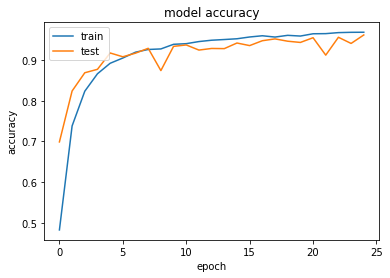

In [18]:
plt.plot(fit.history['accuracy'])
plt.plot(fit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
model_name = "TSR_Model_96perEpoch35_MACM1"

In [20]:
model.save(f'./MODELS/{model_name}')

2021-12-19 21:07:21.461752: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./MODELS/TSR_Model_96perEpoch35_MACM1/assets


In [21]:
model = models.load_model(f'./MODELS/{model_name}')
model.compile(
    optimizer = optimizer, 
    loss = "categorical_crossentropy", 
    metrics = ["accuracy"]
)

## Prediction

In [22]:
signDict = {}

for i in range(len(Ytrain)):
    
    classs = np.argmax(Ytrain[i])
    
    if classs not in signDict.keys():
        signDict[classs] = i

print(signDict)

{7: 0, 8: 1, 10: 2, 2: 3, 38: 4, 5: 5, 1: 6, 25: 7, 3: 10, 23: 12, 13: 14, 17: 16, 26: 17, 31: 18, 14: 21, 18: 26, 4: 32, 35: 33, 29: 34, 12: 35, 16: 36, 22: 39, 20: 45, 6: 48, 11: 50, 34: 55, 15: 70, 37: 88, 9: 97, 33: 99, 41: 108, 28: 115, 40: 121, 36: 160, 27: 178, 19: 180, 39: 181, 0: 204, 30: 214, 24: 220, 42: 235, 21: 331, 32: 448}


In [23]:
imagePredictionSRC = os.path.join(data_path, "Test/00111.png")

### Load image 

In [24]:
image = cv2.imread(imagePredictionSRC)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [25]:
image_rs = cv2.resize(image, (img_size, img_size), 3)        

R, G, B = cv2.split(image_rs)     

img_r = cv2.equalizeHist(R)
img_g = cv2.equalizeHist(G)
img_b = cv2.equalizeHist(B)        

image = cv2.merge((img_r, img_g, img_b))

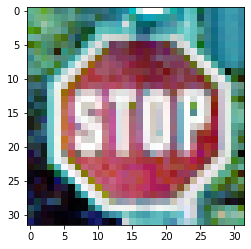

In [26]:
plt.imshow(image)

In [27]:
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
input_arr = input_arr.astype('float32') / 255. 

In [28]:
predictions = model.predict(input_arr)
predicted_class = np.argmax(predictions, axis=-1)[0]

2021-12-19 21:08:05.123569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


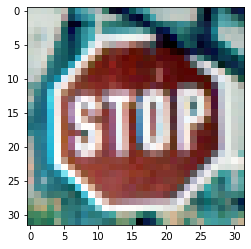

In [29]:
plt.imshow(Xtrain[signDict[predicted_class]])